# Lesson 1: Setting Up

This notebook is designed to run in Google Colab or local Jupyter.

**Colab steps:** Open the notebook, run the setup cell below, then run cells top-to-bottom.

## Learning Objectives
- Describe the inverted pendulum task and success criteria.
- Set up the Python/Jupyter environment for the lab.
- Summarize the system dynamics and state variables.

### Parameters (update as needed)
| Symbol | Meaning | Example |
| --- | --- | --- |
| m_c | Cart mass | 0.5 kg |
| m_p | Pendulum mass | 0.2 kg |
| l | Pendulum length | 0.3 m |
| g | Gravity | 9.81 m/s^2 |
| dt | Sample time | 0.01 s |

---
## Lesson Content

In [1]:
# Install required packages (Colab)
!pip -q install numpy scipy matplotlib


## Control-first exploration (black box)
Before equations, treat the pendulum as a black box.

- Apply small and large force pulses and record cart position and pole angle.
- Change `mass_cart`, `mass_pendulum`, `length`, and `friction` one at a time.
- Note which parameter changes dominate the behavior and which barely matter.
- If you implement Euler, compare it with RK4 and record when it fails.

Answer in 5-8 lines:
1) What states must exist for this motion?
2) What input and disturbance do you believe are present?
3) What failure modes did you observe?

Deliverable: a short "system hypothesis" summary.


# Inverted Pendulum Task Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.


Remember that you are required to write a short report and presentation summarizing the findings from the lab sessions.

Content:
- *Objective:* What was the purpose of this lab exercise?
- *Procedure:* Describe how your group approached the tuning process.
- *Results:* Present the simulation results before and after tuning.
- *Analysis:* Discuss the effects of the PID gains on system performance.
- *Conclusion:* What did you learn about PID control systems?

In [2]:
import IPython
from IPython.display import Image
Image(url='https://www.gymlibrary.dev/_images/cart_pole.gif')

# Setting up the environment
This section introduces the inverted pendulum task and displays a visualization of the environment.

In [3]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
from pathlib import Path

class InvertedPendulum:
    def __init__(self, dt=0.02):
        # System constants
        self.gravity = 9.8        # Acceleration due to gravity (m/s^2)
        self.mass_cart = 1.0      # Mass of the cart (kg)
        self.mass_pole = 0.1      # Mass of the pole (kg)
        self.length = 0.5         # Length of the pole (m)
        self.dt = dt              # Time step (s)

        # Small viscous damping to prevent energy growth
        self.cart_damping = 0.05  # Cart damping (N*s/m)
        self.pole_damping = 0.02  # Pole damping (N*m*s/rad)

        # State variables: [cart position, cart velocity, pole angle, pole angular velocity]
        self.state = np.zeros(4)

        self.save_dir = 'temp/'
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)

    def reset(self):
        """Resets the system state to a small random initial condition."""
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return self.state

    def step(self, force):
        """
        Takes an action (force) and updates the system state.
        Args:
            force (float): Force applied to the cart (N)
        Returns:
            np.array: Updated state [cart position, cart velocity, pole angle, pole angular velocity]
        """
        x, x_dot, theta, theta_dot = self.state

        # Constants for easier calculations
        total_mass = self.mass_cart + self.mass_pole
        pole_mass_length = self.mass_pole * self.length
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        # # Equations of motion
        # temp = (force + pole_mass_length * theta_dot**2 * sin_theta) / total_mass
        # theta_acc = (self.gravity * sin_theta - cos_theta * temp) / (
        #     self.length * (4.0 / 3.0 - self.mass_pole * cos_theta**2 / total_mass)
        # )

        # x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass

        x_acc = (force + self.mass_pole*sin_theta*(self.length*theta_dot**2 - self.gravity * cos_theta)) / (self.mass_cart + self.mass_pole * sin_theta**2)
        theta_acc = (-1*force * cos_theta - self.mass_pole*self.length*theta_dot**2*sin_theta*cos_theta + (self.mass_cart + self.mass_pole)*self.gravity*sin_theta) /  (self.length*(self.mass_cart + self.mass_pole * sin_theta**2))

        # Simple viscous damping terms
        x_acc -= self.cart_damping * x_dot
        theta_acc -= self.pole_damping * theta_dot

        # Update state using Euler integration
        x += self.dt * x_dot
        x_dot += self.dt * x_acc
        theta += self.dt * theta_dot
        theta_dot += self.dt * theta_acc

        self.state = np.array([x, x_dot, theta, theta_dot])
        return self.state

    def render(self, file_idx=0, title="Inverted Pendulum"):
        """
        Plots the cart and pole position with a specified title for Colab.

        Args:
            title (str): Title to display on the plot.
        """
        x, _, theta, _ = self.state

        # Cart dimensions
        cart_width = 0.3
        cart_height = 0.2

        # Pole position
        pole_x = x + self.length * np.sin(theta)
        pole_y = self.length * np.cos(theta)

        # Clear previous output
        clear_output(wait=True)

        # Create a new figure
        plt.figure(figsize=(8, 4))
        plt.xlim(-2, 2)
        plt.ylim(-1, 1)
        plt.grid()

        # Draw the cart
        cart_rect = Rectangle((x - cart_width / 2, -cart_height / 2), cart_width, cart_height, color="blue")
        plt.gca().add_patch(cart_rect)

        # Draw the pole
        plt.plot([x, pole_x], [0, pole_y], color="red", linewidth=2)

        # Draw the pivot point
        plt.plot(x, 0, 'ko', markersize=5)

        # Set the title
        plt.title(title)

        # # Save figure
        # plt.savefig(self.save_dir + str(file_idx) + '.png')

        # Display the updated plot
        plt.show()

### Quick exploration prompt
Predict what happens before running the pulse test. After running, explain any mismatches.


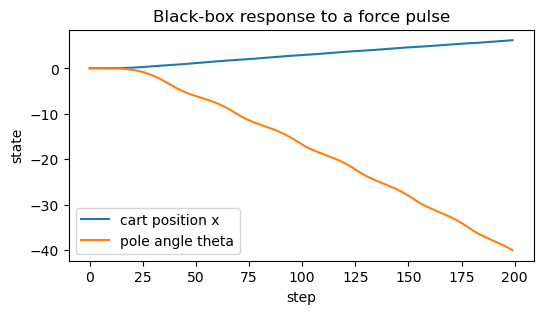

In [4]:
# Black-box exploration (quick pulse experiment)
# Keep this lightweight so it runs fast on Colab.

env_explore = InvertedPendulum(dt=0.02)
# Try changing these values and rerun
env_explore.mass_cart = 1.0
env_explore.mass_pendulum = 0.2
env_explore.length = 0.3
env_explore.friction = 0.1

force = np.zeros(200)
force[10:30] = 5.0  # pulse input

states = []
state = env_explore.reset()
for u in force:
    state = env_explore.step(u)
    states.append(state)

states = np.array(states)
plt.figure(figsize=(6, 3))
plt.plot(states[:, 0], label='cart position x')
plt.plot(states[:, 2], label='pole angle theta')
plt.title('Black-box response to a force pulse')
plt.xlabel('step')
plt.ylabel('state')
plt.legend()
plt.show()


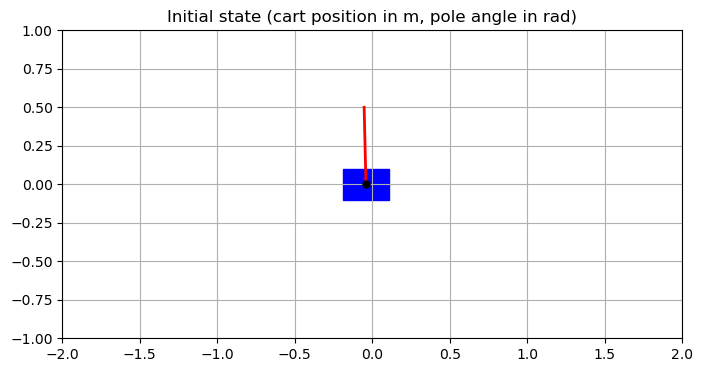

In [5]:
# Render a single frame to verify the visualization
pendulum = InvertedPendulum()
pendulum.reset()
pendulum.render(title='Initial state (cart position in m, pole angle in rad)')


**Expected output:**
- A cart-and-pole render appears without errors; the pole starts near upright and the cart is near center.

Running simulation (with display)

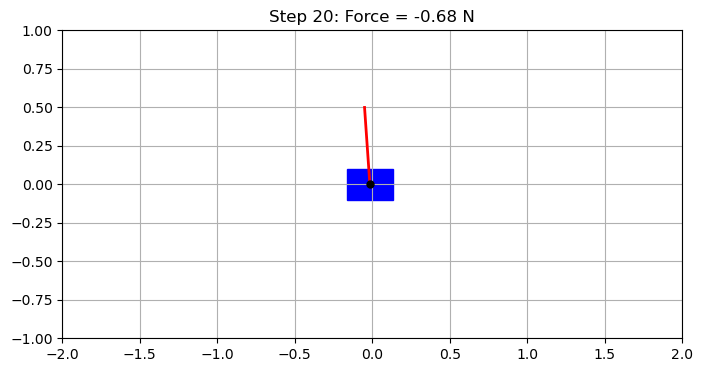

Step: 19 , States: [-0.01609071  0.01826671 -0.06852011 -0.28758465]


In [6]:
# Create an instance of the inverted pendulum system
pendulum = InvertedPendulum()

# Reset the system to a random initial state
states = pendulum.reset()

states_list = [] # List to save states for plot later
action_list = [] # List to save actions for plot later

SIMULATION_STEPS = 20 # number of time steps to take in simulation

# Simulate the system with random forces and render the results
for step in range(SIMULATION_STEPS):
    action = np.random.uniform(-1, 1)  # Random action in the range [-10, 10] N
    states = pendulum.step(action) # Apply action on cart

    # Saving for plots later
    states_list.append(states)
    action_list.append(action)

    pendulum.render(file_idx=step, title=f"Step {step + 1}: Force = {action:.2f} N") # Display function
    print('Step:', step, ', States:', states)

Plotting the states of the system.

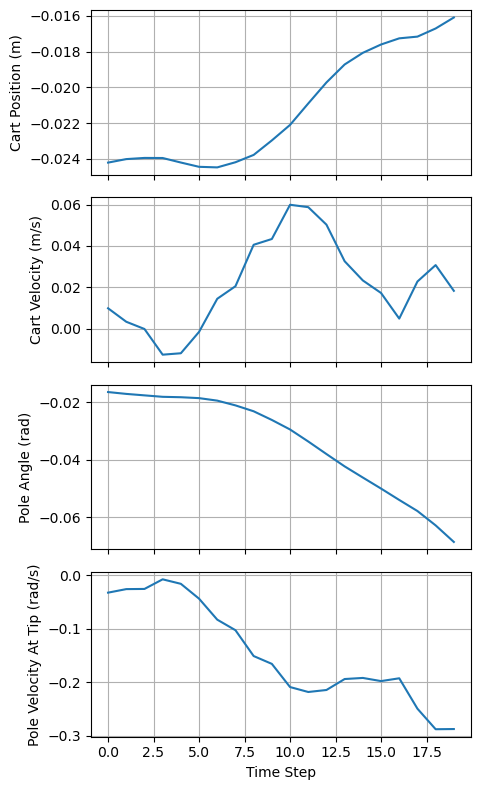

In [7]:
import matplotlib.pyplot as plt

num_states = len(states_list[0])  # Number of observatioSns per step
fig, axes = plt.subplots(num_states, 1, sharex=True, figsize=(5, 2 * num_states))

# Y-axis labels
y_labels = ["Cart Position (m)", "Cart Velocity (m/s)", "Pole Angle (rad)", "Pole Velocity At Tip (rad/s)"]

for i in range(num_states):
    states_values = [s[i] for s in states_list]
    axes[i].plot(states_values)
    axes[i].set_ylabel(y_labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

## **Task:** Understand the System Dynamics (15 mins)

To get a deeper understanding of how the inverted pendulum works and how the system state evolves.

- Run the simulation with zero force input and observe the behavior of the pendulum.

  -  What happens to the cart and pole when no external force is applied?
  - How does the pole behave over time?

- Change initial conditions:

  - Modify the initial position of the cart and the angle of the pole. Run the simulation and observe the difference in behavior.
  - How does the system behave when the pole starts at a larger angle (e.g., 0.5 radians)?

In [8]:
np.random.uniform(-0.05, 0.05)

-0.04293396308086433

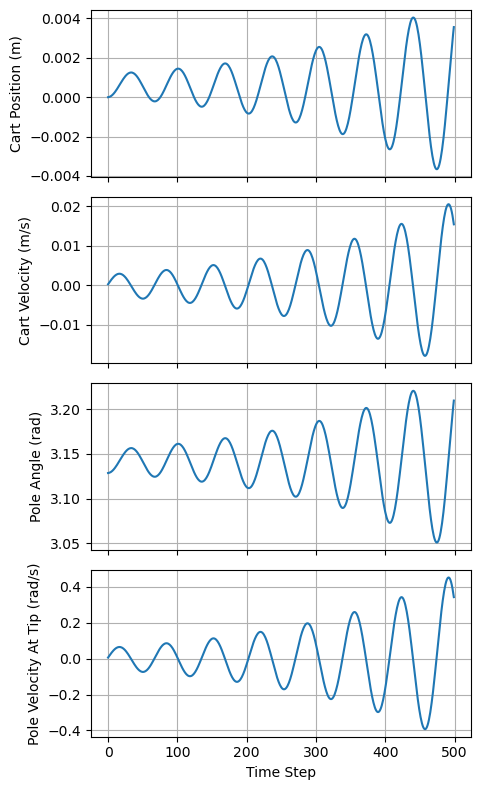

In [9]:
# Create an instance of the inverted pendulum system
pendulum = InvertedPendulum()

# Reset the system to a random initial state
states = pendulum.reset()

### TODO: Vary initial pole position (state[2]) & velocity (state[3]) here.
pendulum.state[0] = 0.0
pendulum.state[1] = 0.0
pendulum.state[2] = math.pi + np.random.uniform(-0.05, 0.05)
pendulum.state[3] = 0.0 # + np.random.uniform(-0.05, 0.05)

states_list = [] # List to save states for plot later
action_list = [] # List to save actions for plot later

SIMULATION_STEPS = 500 # number of time steps to take in simulation


# Simulate the system with random forces and render the results
for step in range(SIMULATION_STEPS):

    # TODO: Vary fource applied on cart
    action = 0.0 # np.random.uniform(-1, 1)  # Random action in the range [-10, 10] N

    states = pendulum.step(action) # Apply action on cart

    # Saving for plots later
    states_list.append(states)
    action_list.append(action)

    ## Switching off display
    # pendulum.render(title=f"Step {step + 1}: Force = {action:.2f} N") # Display function
    # print(states)


num_states = len(states_list[0])  # Number of observatioSns per step
fig, axes = plt.subplots(num_states, 1, sharex=True, figsize=(5, 2 * num_states))

# Y-axis labels
y_labels = ["Cart Position (m)", "Cart Velocity (m/s)", "Pole Angle (rad)", "Pole Velocity At Tip (rad/s)"]

for i in range(num_states):
    states_values = [s[i] for s in states_list]
    axes[i].plot(states_values)
    axes[i].set_ylabel(y_labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

## Prediction -> simulate -> explain
Pick one input (pulse or step). Write a 2-3 line prediction before running. After running, explain what differed and why.


---
## Checkpoints
- Environment launches without errors in Colab or local Jupyter.
- You can explain each state variable and input in one sentence.

## Common Pitfalls
- Mixing units (degrees vs radians) in equations or plots.
- Skipping kernel restart after installing packages.